# Graph Analytics Demo: NFL game 2013 (Ravens vs. Broncos) 

<img src="RavensVsBroncos.png">

In [1]:
import trustedanalytics as ta

In [2]:
ta.connect()

Connected.  This client instance connected to server http://localhost:9099/v1 (version=TheReneNumber) as user test_api_key_1 at 2016-08-04 09:31:08.772139.


## Import frames from CSV files located HDFS

In [3]:
# create vertex frame schema
#=======================
vschema= [("id",ta.int32),("number",ta.int32),("player_name",str),("age",ta.int32),("team",str),("position",str)]
v_csv = ta.CsvFile("/nflgamedata/NFLgame2013vertices_players_fv.csv",vschema,skip_header_lines=1)

In [4]:
#create edge frame schema
#====================
eschema= [("the_doer",str),("the_receiver",str),("play_type",str),("play_evaluation",str),("penalty_type",str),("penalty_on",str),("pass_location",str),("quarter",ta.int32),("min",ta.int32),("sec",ta.int32),("off",str),("def",str),("down",ta.int32),("yards_to_go",ta.int32),("yard_line",ta.int32),("yards_done",ta.int32),("injuries",str),("score_type",str),("off_score",ta.int32),("def_score",ta.int32)]
e_csv = ta.CsvFile("/nflgamedata/NFLgame2013_edges_full_fv.csv",eschema,skip_header_lines=1)

In [5]:
#load the verticses CSV file into a frame
#========================================
vertex_frame = ta.Frame(v_csv)
vertex_frame.inspect()

Done [=========================] 100.00% Time 00:00:05


[#]  id  number  player_name  age  team              position
[0]   1      51  D.Smith       31  Baltimore Ravens  MLB
[1]   2      32  J.Ihedigbo    30  Baltimore Ravens  SS
[2]   3      21  L.Webb        28  Baltimore Ravens  LCB
[3]   4      55  T.Suggs       31  Baltimore Ravens  LB
[4]   5      24  C.Graham      28  Baltimore Ravens  cb
[5]   6      26  M.Elam        22  Baltimore Ravens  FS
[6]   7      22  J.Smith       25  Baltimore Ravens  RCB
[7]   8      97  A.Jones       27  Baltimore Ravens  DT
[8]   9      53  J.McClain     28  Baltimore Ravens  lb/mlb
[9]  10      92  H.Ngata       29  Baltimore Ravens  NT

In [6]:
#load the the edges CSV file into a frame
#========================================
edge_frame = ta.Frame(e_csv)
edge_frame.inspect()

Done [=========================] 100.00% Time 00:00:01


[#]  the_doer   the_receiver  play_type  play_evaluation  penalty_type         
[0]  M.Prater   BAL           kickoff    touchback
[1]  J.Flacco   R.Rice        pass       complete
[2]  R.Rice     D.Ihenacho    rush       rush
[3]  J.Flacco   B.Stokley     pass       complete         off pass interference
[4]  S.Koch     M.Cox         punt       k out of bounds
[5]  P.Manning  J.Thomas      pass       incomplete
[6]  K.Moreno   T.Suggs       rush       rush
[7]  K.Moreno   J.Bynes       rush       rush
[8]  P.Manning  W.Welker      pass       complete
[9]  P.Manning  E.Decker      pass       incomplete

[#]  penalty_on  pass_location  quarter  min  sec  off  def  down  yards_to_go
[0]                                   1    0    0  DEN  BAL     0            0
[1]              short middle         1   60    0  BAL  DEN     1           10
[2]                                   1   59   14  BAL  DEN     2           11
[3]  J.Jones     short left           1   58   38  BAL  DEN     3        

## Build a graph

In [7]:
graph = ta.Graph()

In [8]:
#define vertex type and add vertices
#===================================
graph.define_vertex_type('players')
graph.vertices['players'].add_vertices(vertex_frame,'player_name',['number','age','team','position'])

Done [=========================] 100.00% Time 00:00:01
Done [=========================] 100.00% Time 00:00:02


In [9]:
#define edge type and add edges
#==============================
graph.define_edge_type('play_details','players', 'players', directed=True)
graph.edges['play_details'].add_edges(edge_frame, 'the_doer', 'the_receiver',['play_type','play_evaluation','penalty_type','penalty_on','pass_location','min','sec','quarter','off','def','down','yards_to_go','yard_line','yards_done','injuries','score_type','off_score','def_score'])

Done [=========================] 100.00% Time 00:00:01
Done [=========================] 100.00% Time 00:00:02


In [10]:
graph

Graph <unnamed>
status = ACTIVE  (last_read_date = 2016-08-04T09:31:21.597000-07:00)
vertices = 
  players : [player_name, number, age, team, position], count = 104
edges = 
  play_details : [play_type, play_evaluation, penalty_type, penalty_on, pass_location, min, sec, quarter, off, def, down, yards_to_go, yard_line, yards_done, injuries, score_type, off_score, def_score], count = 219

## Summarize play types by team

In [11]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

### Use copy, filter and group_by functions to summarize play types

In [12]:
#play types summary
#Bal-Revens: 
bal_edge_frame = graph.edges['play_details'].copy()
bal_edge_frame.filter(lambda row: row.off=='BAL')
bal_play_summ = bal_edge_frame.group_by('play_type',ta.agg.count)
#Den-Broncos
den_edge_frame = graph.edges['play_details'].copy()
den_edge_frame.filter(lambda row: row.off=='DEN')
den_play_summ = den_edge_frame.group_by('play_type',ta.agg.count)

Done [=========================] 100.00% Time 00:00:01
Done [=========================] 100.00% Time 00:00:02
Done [=========================] 100.00% Time 00:00:01
Done [=========================] 100.00% Time 00:00:01
Done [=========================] 100.00% Time 00:00:02
Done [=========================] 100.00% Time 00:00:01


In [13]:
print("Denver-Broncos")
den_play_summ.inspect()

Denver-Broncos


[#]  play_type   count
[0]  kickoff         8
[1]  kneel           2
[2]  pass           45
[3]  noplay          6
[4]  punt            7
[5]  rush           26
[6]  extrapoint      7

In [14]:
print("Baltimore-Ravens")
bal_play_summ.inspect()

Baltimore-Ravens


[#]  play_type   count
[0]  kickoff         6
[1]  pass           69
[2]  noplay          3
[3]  punt           10
[4]  fieldgoal       2
[5]  rush           25
[6]  extrapoint      3

## Summarize the scores types by team

In [15]:
#Bal
bal_edge_frame.filter(lambda row: row.score_type !='')
bal_scores_summ= bal_edge_frame.group_by('score_type',ta.agg.count)
#Den
den_edge_frame.filter(lambda row: row.score_type!='')
den_scores_summ= den_edge_frame.group_by('score_type',ta.agg.count)

Done [=========================] 100.00% Time 00:00:02
Done [=========================] 100.00% Time 00:00:01
Done [=========================] 100.00% Time 00:00:02
Done [=========================] 100.00% Time 00:00:01


In [16]:
print("Baltimore-Ravens")
bal_scores_summ.inspect()

Baltimore-Ravens


[#]  score_type  count
[0]  fieldgoal       2
[1]  extrapoint      3
[2]  touchdown       3

In [17]:
print("Denver-Broncos")
den_scores_summ.inspect()

Denver-Broncos


[#]  score_type  count
[0]  extrapoint      7
[1]  touchdown       7

## The 4th down play type:  what was the coach decision at the 4th down?

Done [=========================] 100.00% Time 00:00:01
Done [=========================] 100.00% Time 00:00:02
Done [=========================] 100.00% Time 00:00:02
Done [=========================] 100.00% Time 00:00:01
Done [=========================] 100.00% Time 00:00:01
Done [=========================] 100.00% Time 00:00:02
Done [=========================] 100.00% Time 00:00:02
Done [=========================] 100.00% Time 00:00:01


<function matplotlib.pyplot.show>

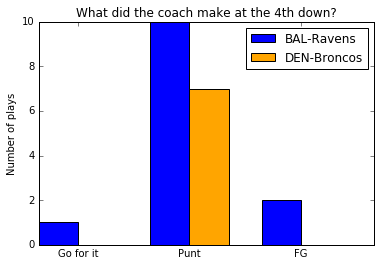

In [18]:
# Get Den 4th down data 
edges_frame = graph.edges['play_details'].copy()
edges_frame.filter(lambda row: row.down== 4)
edges_frame.filter(lambda row: row.off=='DEN')
DEN_4th_down_play = edges_frame.group_by('play_type',ta.agg.count)
# Get Bal 4th down data
edges_frame2 = graph.edges['play_details'].copy()
edges_frame2.filter(lambda row: row.down== 4)
edges_frame2.filter(lambda row: row.off=='BAL')
BAL_4th_down_play = edges_frame2.group_by('play_type',ta.agg.count)

# plot the results
ind = np.arange(3)
width = 0.35       
fig, ax = plt.subplots()
rects1 = ax.bar(ind,(1,10,2), width, color='b')
rects2 = ax.bar(ind+width,(0,7,0), width, color='orange')
ax.set_ylabel('Number of plays')
ax.set_title('What did the coach make at the 4th down?')
ax.set_xticks(ind + width)
ax.set_xticklabels(('Go for it','Punt','FG'))
ax.legend((rects1[0], rects2[0]),('BAL-Ravens', 'DEN-Broncos'))
plt.show

## Analyze net yards by team

Done [=========================] 100.00% Time 00:00:01
Done [=========================] 100.00% Time 00:00:02
Done [=========================] 100.00% Time 00:00:01
Done [=========================] 100.00% Time 00:00:01
Done [=========================] 100.00% Time 00:00:02
Done [=========================] 100.00% Time 00:00:01


<function matplotlib.pyplot.show>

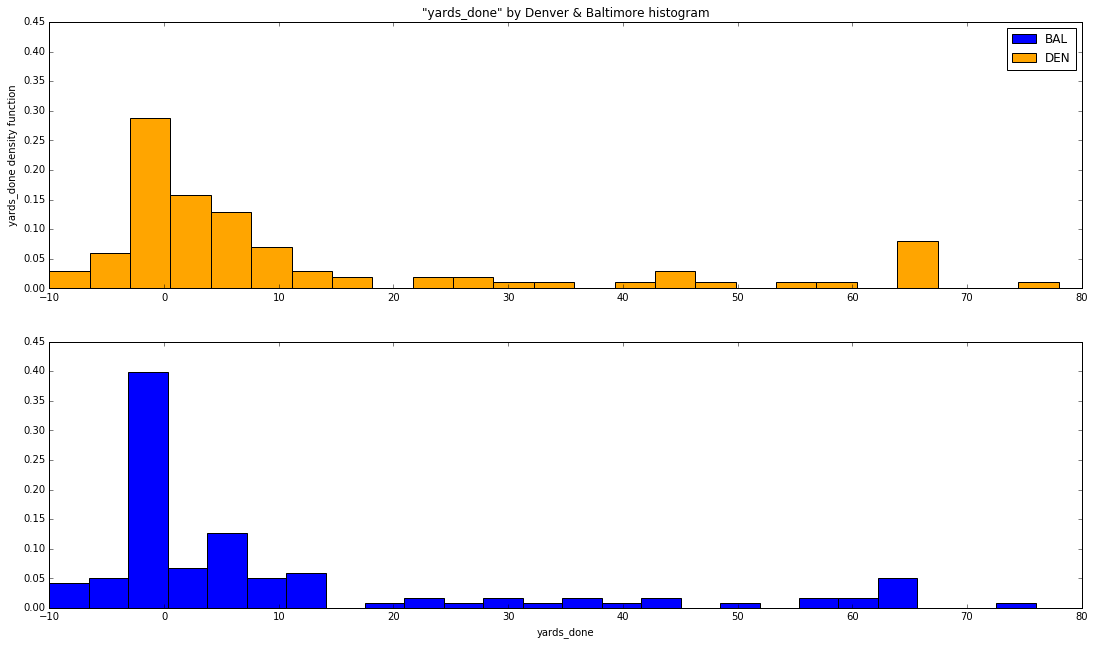

In [19]:
# BAL histogram of yards_done
edge_frame_hist=graph.edges['play_details'].copy()
edge_frame_hist.filter(lambda row: row.off=='BAL')
hist_bal = edge_frame_hist.histogram("yards_done",num_bins=25)
# DEN histogram of yards_done
edge_frame_hist1=graph.edges['play_details'].copy()
edge_frame_hist1.filter(lambda row: row.off=='DEN')
hist_den = edge_frame_hist1.histogram("yards_done",num_bins=25)

# plot histograms by team
num_bins=25
ind = hist_bal.cutoffs[0:num_bins]
width1 = hist_bal.cutoffs[1]-hist_bal.cutoffs[0]
width2 = hist_den.cutoffs[1]-hist_den.cutoffs[0]
fig,(ax0,ax) = plt.subplots(2,1)
fig.set_size_inches(18.5, 10.5, forward=True)
rects1 = ax.bar(hist_bal.cutoffs[0:num_bins],hist_bal.density,width1,color='blue')
rects2 = ax0.bar(hist_den.cutoffs[0:num_bins],hist_den.density,width2,color='orange')
ax0.set_ylabel('yards_done density function')
ax.set_xlabel('yards_done')
ax0.set_title('"yards_done" by Denver & Baltimore histogram')
ax0.legend((rects1[0], rects2[0]),('BAL', 'DEN'))
ax0.set_ylim(0,0.45)
ax.set_ylim(0,0.45)
plt.show

## Play-by-play analysis (offense-team behavior) 

In [20]:
# BAl-Ravens: Get score types, yard lines and the corresponding time
bal_edge_frame = graph.edges['play_details'].copy()
bal_edge_frame.filter(lambda row: row.off=='BAL')
panda_frame_yards0 = bal_edge_frame.download(columns=['yard_line'])
panda_frame_min0 = bal_edge_frame.download(columns=['min'])
panda_frame_sec0 = bal_edge_frame.download(columns=['sec'])
yards_list = panda_frame_yards0['yard_line'].tolist()
bal_min_list = panda_frame_min0['min'].tolist()
bal_sec_list= panda_frame_sec0['sec'].tolist()
bal_time_list= [x+y/60.0 for x, y in zip(bal_min_list, bal_sec_list)]

#plot the scores vs time:
bal_edge_frame.filter(lambda row: row.score_type !='')
bal_scores_summ= bal_edge_frame.group_by('score_type',ta.agg.count)
panda_frame_min_s = bal_edge_frame.download(columns=['min'])
panda_frame_sec_s = bal_edge_frame.download(columns=['sec'])
bal_min_list_s = panda_frame_min_s['min'].tolist()
bal_sec_list_s= panda_frame_sec_s['sec'].tolist()
bal_time_list_s= [x+y/60.0 for x, y in zip(bal_min_list_s, bal_sec_list_s)]

# Den-Broncos: Get score types, yard lines and the corresponding time
#========================================
den_edge_frame = graph.edges['play_details'].copy()
den_edge_frame.filter(lambda row: row.off=='DEN')
panda_frame_yards1 = den_edge_frame.download(columns=['yard_line'])
panda_frame_min1 = den_edge_frame.download(columns=['min'])
panda_frame_sec1 = den_edge_frame.download(columns=['sec'])
den_yards_list = panda_frame_yards1['yard_line'].tolist()
den_min_list = panda_frame_min1['min'].tolist()
den_sec_list= panda_frame_sec1['sec'].tolist()
den_time_list=[x+y/60.0 for x, y in zip(den_min_list, den_sec_list)]

#the scores vs time:
den_edge_frame.filter(lambda row: row.score_type!='')
den_scores_summ= den_edge_frame.group_by('score_type',ta.agg.count)
panda_frame_min_s1 = den_edge_frame.download(columns=['min'])
panda_frame_sec_s1 = den_edge_frame.download(columns=['sec'])
den_min_list_s = panda_frame_min_s1['min'].tolist()
den_sec_list_s= panda_frame_sec_s1['sec'].tolist()
den_time_list_s= [x+y/60.0 for x, y in zip(den_min_list_s,den_sec_list_s)]

Done [=========================] 100.00% Time 00:00:01
Done [=========================] 100.00% Time 00:00:02
Done [=========================] 100.00% Time 00:00:02
Done [=========================] 100.00% Time 00:00:01
Done [=========================] 100.00% Time 00:00:01
Done [=========================] 100.00% Time 00:00:02
Done [=========================] 100.00% Time 00:00:02
Done [=========================] 100.00% Time 00:00:01


<function matplotlib.pyplot.show>

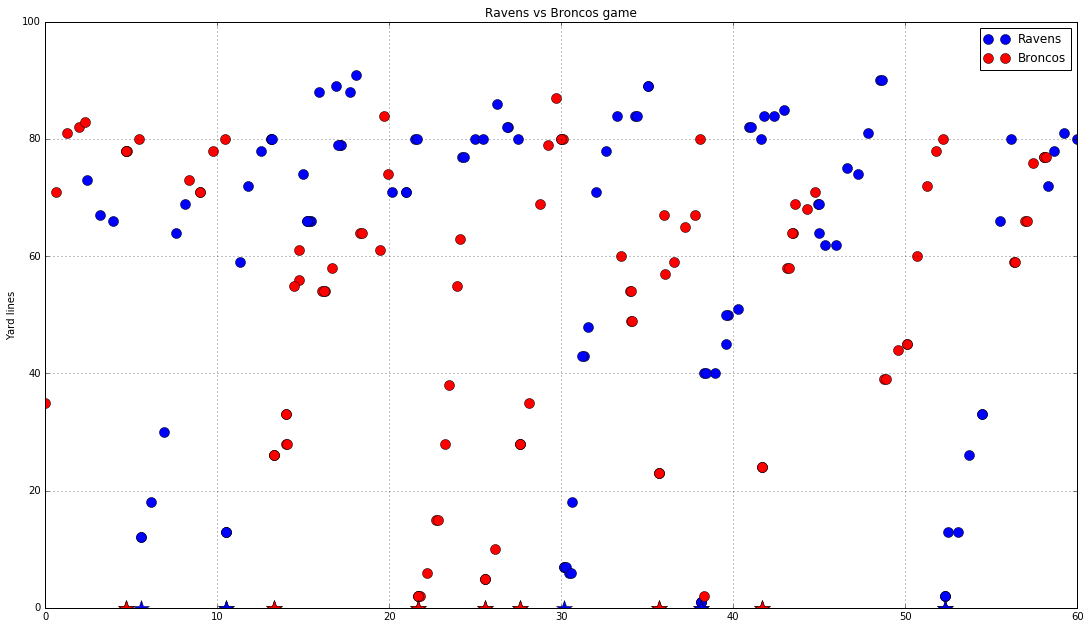

In [21]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.grid(True)
bal_stats=ax.plot(bal_time_list, yards_list,'bo', markersize=10)
den_stats=ax.plot(den_time_list, den_yards_list,'ro', markersize=10)
ax.plot(bal_time_list_s,[0]*len(bal_time_list_s),'b*',markerfacecolor='b', markersize=16)
ax.plot(den_time_list_s,[0]*len(den_time_list_s),'r*',markerfacecolor='r', markersize=16)
ax.set_ylabel('Yard lines')
ax.set_title('Ravens vs Broncos game')
ax.legend((bal_stats[0], den_stats[0]),('Ravens','Broncos'))
plt.show

## Re-structure the graph to smaller sub-graphs

In [44]:
playtypes_graph = ta.Graph()

In [45]:
playtypes_graph.define_vertex_type('players')
playtypes_graph.vertices['players'].add_vertices(vertex_frame,'player_name',['number','age','team','position'])

Done [=========================] 100.00% Time 00:00:01
Done [=========================] 100.00% Time 00:00:01


In [46]:
#play_type: pass
pass_edgeframe = edge_frame.copy(where = lambda row:row.play_type=='pass')
playtypes_graph.define_edge_type('pass','players', 'players', directed=True)
playtypes_graph.edges['pass'].add_edges(pass_edgeframe, 'the_doer', 'the_receiver',['play_type','play_evaluation','penalty_type','penalty_on','pass_location','min','sec','quarter','off','def','down','yards_to_go','yard_line','yards_done','injuries','score_type','off_score','def_score'])

#play_type: rush
rush_edgeframe = edge_frame.copy(where = lambda row:row.play_type=='rush')
playtypes_graph.define_edge_type('rush_by','players', 'players', directed=True)
playtypes_graph.edges['rush_by'].add_edges(rush_edgeframe, 'the_doer', 'the_receiver',['play_type','play_evaluation','penalty_type','penalty_on','pass_location','min','sec','quarter','off','def','down','yards_to_go','yard_line','yards_done','injuries','score_type','off_score','def_score'])

#play_type: punt
punt_edgeframe = edge_frame.copy(where = lambda row:row.play_type=='punt')
playtypes_graph.define_edge_type('punt','players', 'players', directed=True)
playtypes_graph.edges['punt'].add_edges(punt_edgeframe, 'the_doer', 'the_receiver',['play_type','play_evaluation','penalty_type','penalty_on','pass_location','min','sec','quarter','off','def','down','yards_to_go','yard_line','yards_done','injuries','score_type','off_score','def_score'])

#play_type: kickoff
kickoff_edgeframe = edge_frame.copy(where = lambda row:row.play_type=='kickoff')
playtypes_graph.define_edge_type('kickoff','players', 'players', directed=True)
playtypes_graph.edges['kickoff'].add_edges(kickoff_edgeframe, 'the_doer', 'the_receiver',['play_type','play_evaluation','penalty_type','penalty_on','pass_location','min','sec','quarter','off','def','down','yards_to_go','yard_line','yards_done','injuries','score_type','off_score','def_score'])

#play_type: extrapoint
extrapoint_edgeframe = edge_frame.copy(where = lambda row:row.play_type=='extrapoint')
playtypes_graph.define_edge_type('extrapoint','players', 'players', directed=True)
playtypes_graph.edges['extrapoint'].add_edges(extrapoint_edgeframe, 'the_doer', 'the_receiver',['play_type','play_evaluation','penalty_type','penalty_on','pass_location','min','sec','quarter','off','def','down','yards_to_go','yard_line','yards_done','injuries','score_type','off_score','def_score'])

#play_type: kneel
kneel_edgeframe = edge_frame.copy(where = lambda row:row.play_type=='kneel')
playtypes_graph.define_edge_type('kneel','players', 'players', directed=True)
playtypes_graph.edges['kneel'].add_edges(kneel_edgeframe, 'the_doer', 'the_receiver',['play_type','play_evaluation','penalty_type','penalty_on','pass_location','min','sec','quarter','off','def','down','yards_to_go','yard_line','yards_done','injuries','score_type','off_score','def_score'])

#play_type: noplay
noplay_edgeframe = edge_frame.copy(where = lambda row:row.play_type=='noplay')
playtypes_graph.define_edge_type('noplay','players', 'players', directed=True)
playtypes_graph.edges['noplay'].add_edges(noplay_edgeframe, 'the_doer', 'the_receiver',['play_type','play_evaluation','penalty_type','penalty_on','pass_location','min','sec','quarter','off','def','down','yards_to_go','yard_line','yards_done','injuries','score_type','off_score','def_score'])

Done [=========================] 100.00% Time 00:00:02
Done [=========================] 100.00% Time 00:00:01
Done [=========================] 100.00% Time 00:00:02
Done [=========================] 100.00% Time 00:00:02
Done [=========================] 100.00% Time 00:00:01
Done [=========================] 100.00% Time 00:00:02
Done [=========================] 100.00% Time 00:00:02
Done [=========================] 100.00% Time 00:00:01
Done [=========================] 100.00% Time 00:00:02
Done [=========================] 100.00% Time 00:00:02
Done [=========================] 100.00% Time 00:00:01
Done [=========================] 100.00% Time 00:00:02
Done [=========================] 100.00% Time 00:00:02
Done [=========================] 100.00% Time 00:00:01
Done [=========================] 100.00% Time 00:00:02
Done [=========================] 100.00% Time 00:00:02
Done [=========================] 100.00% Time 00:00:01
Done [=========================] 100.00% Time 00:00:02
Done [====

## Export graph to OrientDB

In [55]:
# Export Parquet graph to OrientDB
#=================================
playtypes_graph.export_to_orientdb("NFLgameDBeeee",True)

Done [=========================] 100.00% Time 00:00:03


{u'db_uri': u'plocal:/home/wtaie/graphDBs_home/orientdb-community-2.1.12/databases/NFLgameDBeeee',
 u'exported_edges': {u'extrapoint': {u'exported_count': 10,
   u'failure_count': 0},
  u'kickoff': {u'exported_count': 14, u'failure_count': 0},
  u'kneel': {u'exported_count': 2, u'failure_count': 0},
  u'noplay': {u'exported_count': 9, u'failure_count': 0},
  u'pass': {u'exported_count': 114, u'failure_count': 0},
  u'punt': {u'exported_count': 17, u'failure_count': 0},
  u'rush_by': {u'exported_count': 51, u'failure_count': 0}},
 u'exported_vertices': {u'players': {u'exported_count': 104,
   u'failure_count': 0}}}

In [50]:
playtypes_graph.edges['pass'].inspect()

[#]  _eid  _src_vid  _dest_vid  _label  play_type  play_evaluation  penalty_type
[0]   138        45        104  pass    pass       good
[1]   109        76         79  pass    pass       incomplete
[2]   121        76         79  pass    pass       complete
[3]   129        76         79  pass    pass       incomplete
[4]   171        76         79  pass    pass       incomplete
[5]   184        76         79  pass    pass       incomplete
[6]   192        76         79  pass    pass       k out of bounds
[7]   210        76         79  pass    pass       incomplete
[8]   147        76          4  pass    pass       sack
[9]   110        76         85  pass    pass       incomplete

[#]  penalty_on  pass_location  min  sec  quarter  off  def  down  yards_to_go
[0]                              38    8        2  BAL  DEN     1            1
[1]              deep right      57    4        1  DEN  BAL     1           10
[2]              short right     49   33        1  DEN  BAL     2     

In [52]:
playtypes_graph.vertices['players']

Frame  <unnamed>
row_count = 104
schema = [_vid:int64, _label:unicode, player_name:unicode, number:int32, age:int32, team:unicode, position:unicode]
status = ACTIVE  (last_read_date = 2016-08-04T10:23:10.489000-07:00)

## Import graph from OrientDB

In [56]:
# Import graph from OrientDB to ATK in Parquet format
#===================================================
orientGraph = ta.Graph(ta.OrientDBGraph("NFLgameDBeeee"))

Done [=========================] 100.00% Time 00:00:08


In [57]:
orientGraph

Graph <unnamed>
status = ACTIVE  (last_read_date = 2016-08-04T10:28:32.882000-07:00)
vertices = 
  players : [number, player_name, team, position, age], count = 104
edges = 
  kneel : [def, injuries, yards_done, down, off, score_type, penalty_on, sec, play_evaluation, play_type, pass_location, min, def_score, yard_line, penalty_type, yards_to_go, off_score, quarter], count = 2
  punt : [def, injuries, yards_done, down, off, score_type, penalty_on, sec, play_evaluation, play_type, pass_location, min, def_score, yard_line, penalty_type, yards_to_go, off_score, quarter], count = 17
  extrapoint : [def, injuries, yards_done, down, off, score_type, penalty_on, sec, play_evaluation, play_type, pass_location, min, def_score, yard_line, penalty_type, yards_to_go, off_score, quarter], count = 10
  kickoff : [def, injuries, yards_done, down, off, score_type, penalty_on, sec, play_evaluation, play_type, pass_location, min, def_score, yard_line, penalty_type, yards_to_go, off_score, quarter], coun

In [26]:
ta.release()

Releasing cluster resources...
Done [=========================] 100.00% Time 00:00:01


In [27]:
# to open the OrientDB we just created, need to shutdown the rest-server
import pyorient as pyorient

In [28]:
client = pyorient.OrientDB("localhost", 2424)
session_id = client.connect( "root", "root" )

PyOrientConnectionException: Socket Error: [Errno 111] Connection refused

In [ ]:
client.db_open( "NFLgameDB", "admin", "admin" )

In [ ]:
den_scores_time = client.query("SELECT min,sec,score_type,down,yard_line FROM play_details WHERE score_type in['touchdown','fieldgoal','extrapoint'] and off =='DEN' limit 220")
for time in den_scores_time:
    print("Denver-Broncos scored "+time.score_type +" in down # "+ str(time.down)+"  @  "+ str(time.min) +":"+ str(time.sec))

In [ ]:
bal_scores_time = client.query("SELECT min,sec,score_type,down FROM play_details WHERE score_type in['touchdown','fieldgoal','extrapoint'] and off =='BAL' limit 220")
for time in bal_scores_time:
    print("Baltimore-Ravens scored "+time.score_type +" in down # "+ str(time.down)+"  @  "+ str(time.min) +":"+ str(time.sec))

In [ ]:
client.db_close()